In [1]:
!pip install beautifulsoup4 requests pandas nltk matplotlib seaborn vaderSentiment


  Obtaining dependency information for vaderSentiment from https://files.pythonhosted.org/packages/76/fc/310e16254683c1ed35eeb97386986d6c00bc29df17ce280aed64d55537e9/vaderSentiment-3.3.2-py2.py3-none-any.whl.metadata
   ---------------------------------------- 0.0/126.0 kB ? eta -:--:--
   --------- ------------------------------ 30.7/126.0 kB ? eta -:--:--
   ------------------------- ------------- 81.9/126.0 kB 919.0 kB/s eta 0:00:01
   ------------------------------ ------- 102.4/126.0 kB 980.4 kB/s eta 0:00:01
   -------------------------------------- 126.0/126.0 kB 741.7 kB/s eta 0:00:00


In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

# Downloading VADER lexicon
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Shree\AppData\Roaming\nltk_data...


True

In [3]:
def scrape_books(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    books = []
    for article in soup.find_all('article', class_='product_pod'):
        title = article.h3.a['title']
        price = article.find('p', class_='price_color').text[1:]
        rating = article.p['class'][1]
        book_url = article.h3.a['href']

        # Getting book description
        book_response = requests.get(f"http://books.toscrape.com/catalogue/{book_url}")
        book_soup = BeautifulSoup(book_response.content, 'html.parser')
        description = book_soup.find('meta', {'name': 'description'})
        if description:
            description = description['content'].strip()
        else:
            description = "No description available."

        books.append({'title': title, 'price': float(price), 'rating': rating, 'description': description})

    return books

def scrape_all_pages(base_url, pages):
    all_books = []
    for page in range(1, pages + 1):
        url = f"{base_url}/catalogue/page-{page}.html"
        books = scrape_books(url)
        all_books.extend(books)
    return pd.DataFrame(all_books)


In [5]:
base_url = 'http://books.toscrape.com'
pages = 5  # Number of pages to scrape
df = scrape_all_pages(base_url, pages)
df.to_csv('books.csv', index=False)
print("Books data saved to books.csv")

df.head()

Books data saved to books.csv


,title,price,rating,description
0,A Light in the Attic,51.77,Three,It's hard to imagine a world without A Light i...
1,Tipping the Velvet,53.74,One,"""Erotic and absorbing...Written with starling ..."
2,Soumission,50.10,One,"Dans une France assez proche de la nôtre, un h..."
3,Sharp Objects,47.82,Four,"WICKED above her hipbone, GIRL across her hear..."
4,Sapiens: A Brief History of Humankind,54.23,Five,From a renowned historian comes a groundbreaki...


In [6]:
# Loading data
df = pd.read_csv('books.csv')

# Converting rating to numerical value
rating_map = {'One': 1, 'Two': 2, 'Three': 3, 'Four': 4, 'Five': 5}
df['rating'] = df['rating'].map(rating_map)

# Initializing VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Performing sentiment analysis on book descriptions
df['sentiment'] = df['description'].apply(lambda x: sid.polarity_scores(x)['compound'])

# Saving data with sentiment scores
df.to_csv('books_with_sentiment.csv', index=False)

df.head()

,title,price,rating,description,sentiment
0,A Light in the Attic,51.77,3,It's hard to imagine a world without A Light i...,0.9939
1,Tipping the Velvet,53.74,1,"""Erotic and absorbing...Written with starling ...",0.9769
2,Soumission,50.10,1,"Dans une France assez proche de la nôtre, un h...",0.4215
3,Sharp Objects,47.82,4,"WICKED above her hipbone, GIRL across her hear...",-0.9938
4,Sapiens: A Brief History of Humankind,54.23,5,From a renowned historian comes a groundbreaki...,0.9772


            price      rating   sentiment
count  100.000000  100.000000  100.000000
mean    34.560700    2.930000    0.458900
std     14.638531    1.423149    0.746572
min     10.160000    1.000000   -0.993800
25%     19.897500    2.000000   -0.032000
50%     34.775000    3.000000    0.941700
75%     47.967500    4.000000    0.982950
max     58.110000    5.000000    0.999100


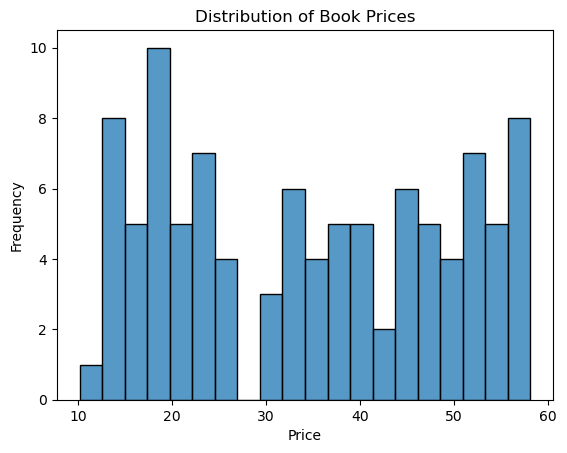

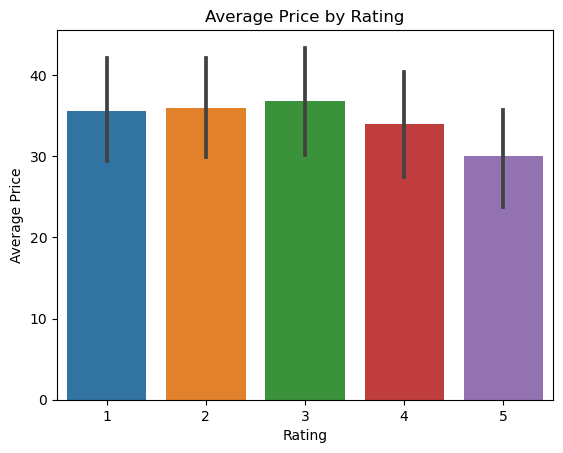

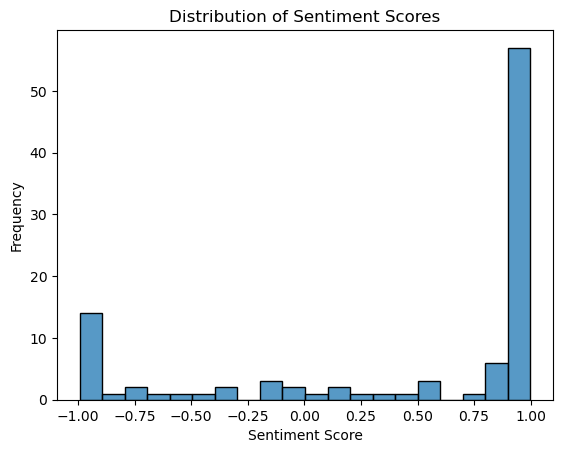

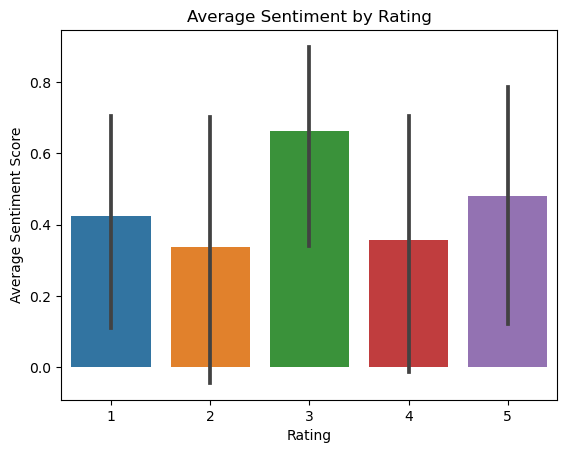

In [7]:

print(df.describe())

# Distribution of book prices
sns.histplot(df['price'], bins=20)
plt.title('Distribution of Book Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Average price by rating
sns.barplot(x='rating', y='price', data=df)
plt.title('Average Price by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Price')
plt.show()

# Sentiment distribution
sns.histplot(df['sentiment'], bins=20)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

# Average sentiment by rating
sns.barplot(x='rating', y='sentiment', data=df)
plt.title('Average Sentiment by Rating')
plt.xlabel('Rating')
plt.ylabel('Average Sentiment Score')
plt.show()
